In [1]:
%matplotlib inline

import os.path as op
import re

import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap

from PIL import Image

import torch
import torch.nn as nn

import spectral.io.envi as envi
from isofit.core.common import resample_spectrum
import rasterio as rio

def name_to_nm(bandname):
    """ Convert wavelength text to float """
    return float(re.search(r'(\d+\.\d+)', bandname).group(1))
    
def get_date(fid):
    """ Get the date string from full FID """
    return fid.split('_')[0].split('t')[1]

def get_rdn_png(root, fid):
    """ Retrieve l1b rdn png from FID """
    matches = glob(op.join(root, get_date(fid), fid.split('_')[0], 'l1b', '*_l1b_rdn_*v01.png'))
    if len(matches) == 0:
        return None
    else:
        return matches[0]

def get_rdn_hdr(root, fid):
    """ Retrieve l1b rdn hdr from FID """
    matches = glob(op.join(root, get_date(fid), fid.split('_')[0], 'l1b', '*_l1b_rdn_*.hdr'))
    if len(matches) == 0:
        return None
    else:
        return matches[0]

def get_obs_hdr(root, fid):
    """ Retrieve l1b obs hdr from FID """
    matches = glob(op.join(root, get_date(fid), fid.split('_')[0], 'l1b', '*_l1b_obs_*.hdr'))
    if len(matches) == 0:
        return None
    else:
        return matches[0]


def l1b_to_toa_arr(rdnfp, obsfp, irrfp):
    """
    Converts Level 1b radiance data to top-of-atmosphere (TOA) reflectance.

    Parameters:
    - rdnfp (str): File path to the radiance data (L1b product).
    - obsfp (str): File path to the observation data (L1b product).
    - irrfp (str): File path to the irradiance data.

    Returns:
    - toa_refl (numpy.ndarray): The calculated top-of-atmosphere reflectance.
    - banddef (numpy.ndarray): Array of band definitions derived from the radiance data.
    - metadata (dict): Metadata from the radiance data header.
    """

    # open radiance
    rad_header = envi.open(rdnfp)
    #rad = rad_header.open_memmap(interleave='bip')
    rad = rad_header.load()
    banddef = np.array([name_to_nm(name) for name in rad_header.metadata['wavelength']], dtype=float)

    # To-sun zenith (0 to 90 degrees from zenith)
    obs = envi.open(obsfp).open_memmap(interleave='bip')
    zen = obs[:,:,4]
    # zen = np.deg2rad(np.average(zen))
    zen = np.deg2rad(zen)

    # Earth-sun distance (AU)
    es_distance = obs[:,:,10]
    es_distance = np.average(es_distance)

    # calculate irr
    # wavelengths
    wl_arr = np.array(rad_header.metadata['wavelength'], dtype=float)
    # full width at half maximum
    fwhm_arr = np.array(rad_header.metadata['fwhm'], dtype=float)

    irr_arr = np.load(irrfp)
    irr_resamp = resample_spectrum(irr_arr[:,1], irr_arr[:,0], wl_arr, fwhm_arr)
    irr_resamp = np.array(irr_resamp, dtype=float)
    irr = irr_resamp * (es_distance ** 2)

    # Top of Atmosphere Reflectance
    toa_refl = (np.pi / np.cos(zen[:, :, np.newaxis])) * (rad / irr[np.newaxis, np.newaxis, :])

    return toa_refl, banddef, rad_header.metadata

class BandConcat(nn.Module):
    """Concatenate band wavelength to reflectance spectra."""

    def __init__(self, banddef):
        super().__init__()
        self.banddef = torch.unsqueeze(banddef, -1)
        self.banddef = torch.unsqueeze(self.banddef, 0)
        self.banddef = (self.banddef - torch.mean(self.banddef)) / torch.std(self.banddef)

    def forward(self, spectra):
        """ 
            spectra: (b, s, 1)
            banddef: (s, 1)
        """
        encoded = torch.cat((spectra, self.banddef.expand_as(spectra)), dim=-1)
        return encoded

class SpectralEmbed(nn.Module):
    """Embed spectra and bands using Conv1D"""

    def __init__(self, n_filters: int = 128):
        super().__init__()
        self.linear = nn.Linear(2, n_filters)
    
    def forward(self, x):
        x = self.linear(x)
        x = torch.tanh(x)
        return x

class SimpleSeqClassifier(nn.Module):
    def __init__(self, 
                 banddef,
                 num_classes: int = 2,
                 num_layers: int = 1,
                 num_heads: int = 8,
                 dim_proj: int = 32,
                 dim_ff: int = 128,
                 dropout: float = 0.1,
                 proj_ker: int = 1,
                 proj_str: int = 1,
                 agg: str = 'max'):
        super().__init__()

        # Embedding
        self.band_concat = BandConcat(banddef)
        self.spectral_embed = SpectralEmbed(n_filters=dim_proj)

        # Attention
        self.self_attn = nn.MultiheadAttention(dim_proj, num_heads, dropout=dropout, bias=True, batch_first=True)

        # Feedforward
        self.linear1 = nn.Linear(dim_proj, dim_ff, bias=True)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_ff, dim_proj, bias=True)

        # Normalization
        self.norm1 = nn.LayerNorm(dim_proj, eps=1e-5, bias=True)
        self.norm2 = nn.LayerNorm(dim_proj, eps=1e-5, bias=True)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.gelu = torch.nn.functional.gelu

        # Classification
        self.aggregate = agg
        self.classifier = nn.Linear(dim_proj, num_classes)
        self.initialize_weights()


    def forward(self, x):
        x = self.band_concat(x)
        x = self.spectral_embed(x)

        # Transformer without skip connections
        x = self._sa_block(self.norm1(x))
        x = self._ff_block(self.norm2(x))

        if self.aggregate == 'mean':
            x = torch.mean(x, dim=1)
        elif self.aggregate == 'max':
            x,_ = torch.max(x, dim=1)
        x = self.classifier(x)
        return x

    def initialize_weights(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.Conv1d)):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)

    def _sa_block(self, x):
        x = self.self_attn(x, x, x)[0]
        return self.dropout1(x)
    
    def _ff_block(self, x):
        x = self.linear2(self.dropout(self.gelu(self.linear1(x))))
        return self.dropout2(x)

def drop_banddef(
        banddef,
        wls=[381.0055, 388.4092, 395.8158, 403.2254, 
            1275.339, 1282.794, 1290.25, 1297.705, 1305.16, 1312.614, 1320.068,
            2455.994, 2463.381, 2470.767, 2478.153, 2485.538, 2492.923]):
    """
    Update banddef to remove specified wavelengths
    """

    dropbands = []
    for wl in wls:
        deltas = np.abs(banddef - wl)
        dropbands.append(np.argmin(deltas))
    
    banddef = np.delete(banddef, dropbands, axis=0)
    
    return banddef

def drop_bands(
        spectra, 
        banddef,
        wls=[381.0055, 388.4092, 395.8158, 403.2254, 
            1275.339, 1282.794, 1290.25, 1297.705, 1305.16, 1312.614, 1320.068,
            2455.994, 2463.381, 2470.767, 2478.153, 2485.538, 2492.923],
        nan=True):
    """
    Removes bands/wavelengths of high uncertainty from a single spectra or an array of spectras.
    """

    dropbands = []
    for wl in wls:
        deltas = np.abs(banddef - wl)
        dropbands.append(np.argmin(deltas))
    
    if nan:
        if len(spectra.shape) == 2:
            spectra[:,dropbands] = np.nan
        else:
            spectra[dropbands] = np.nan
    else:
        if len(spectra.shape) == 2:
            spectra = np.delete(spectra, dropbands, axis=1)
        else:
            spectra = np.delete(spectra, dropbands, axis=0)
        banddef = np.delete(banddef, dropbands, axis=0)
    
    return spectra, banddef

def get_attn(banddef, spectrum, modelpath):
    
    banddef_dropped = torch.tensor(
        drop_banddef(banddef)
    ).float()

    model = SimpleSeqClassifier(banddef = banddef_dropped,
                                num_classes=2,
                                num_layers=1,
                                num_heads=8,
                                dim_proj=64,
                                dim_ff=64,
                                dropout=0,
                                proj_ker=1,
                                proj_str=1,
                                agg='max').to('cpu', dtype=torch.float)

    print("loading", modelpath)
    model.load_state_dict(torch.load(modelpath, map_location='cpu'))
    model.eval()
    
    
    spectrum, _ = drop_bands(spectrum, banddef, nan=False)
    
    with torch.no_grad():
        x = torch.tensor(spectrum).unsqueeze(0).unsqueeze(-1).float()
        x = model.band_concat(x)
        x = model.spectral_embed(x)
        x = model.norm1(x)
        attn_out, attn = model.self_attn(x, x, x, need_weights=True)

        x = model._ff_block(model.norm2(attn_out))
        x, _ = torch.max(x, dim=1)
        x = model.classifier(x)
        print('out', x)
        proba = nn.functional.softmax(x, dim=1)
        print('proba', proba)

    attn_matrix = attn.numpy().transpose(1, 2, 0)
    attn_sum = np.sum(attn_matrix, axis=0)

    return attn_matrix, attn_sum, attn_out

def get_raster(dir, fid, ext='img'):
    return glob(op.join(dir, f"{fid}*.{ext}"))[0]

def plot_png(path, ax, title=''):
    arr = Image.open(path)
    ax.imshow(arr)
    ax.set_title(title)
    ax.axis('off')

Loading TOA...
Done. (1280, 1242, 285)


/home/jakelee/micromamba/envs/emit-cloud/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


loading /home/jakelee/cloud/models/v6_m4.pt
out tensor([[ 6.3311, 14.9945]])
proba tensor([[1.7277e-04, 9.9983e-01]])


/tmp/ipykernel_91203/3382739868.py:70: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


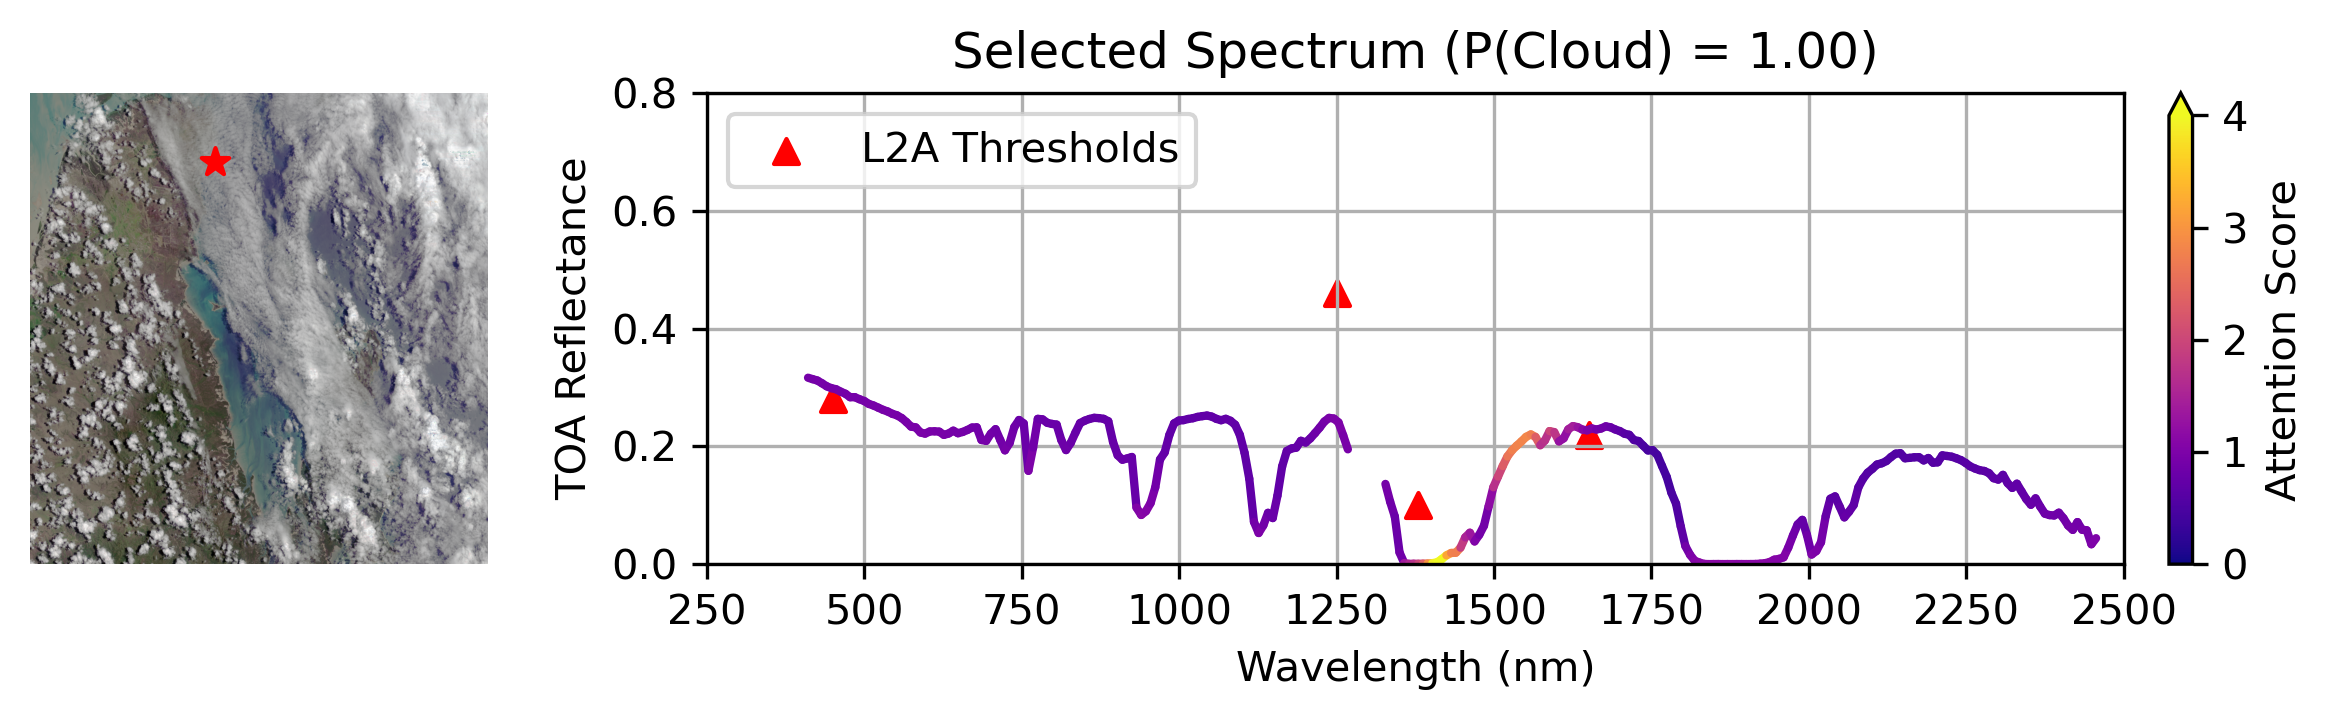

In [2]:
ACQROOT = '/store/emit/ops/data/acquisitions/'
OUTROOT = '/scratch/jakelee/emit-cloud/outputs/v6_m4/20241016/'
MODEL = '/home/jakelee/cloud/models/v6_m4.pt'
FID = "emit20240302t005829"

rgb_fp = get_rdn_png(ACQROOT, FID)
rdn_fp = get_rdn_hdr(ACQROOT, FID)
obs_fp = get_obs_hdr(ACQROOT, FID)

print('Loading TOA...')
TOA_arr, banddef, _ = l1b_to_toa_arr(rdn_fp, obs_fp, '/home/jakelee/cloud/emit-cloud-screening/jakelee/irr.npy')
print('Done.', TOA_arr.shape)

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(8,2.5), dpi=300, gridspec_kw={'width_ratios': [1, 3]})

rgb = get_raster(op.join(OUTROOT, 'rgb_png'), FID, ext='png')
plot_png(rgb, ax0, '')

tf_mask = get_raster(op.join(OUTROOT, 'tf_mask_nodata'), FID)
mask_arr = rio.open(tf_mask).read(1)

x=503
y=188
drop = [120, 121, 122, 123, 124, 125, 126]

# Get spectrum
spec = TOA_arr[y][x]

# Get probability
proba = mask_arr[y][x]
#proba = mask_arr[x][y]

# Get attention
_, attn_sum, attn_out = get_attn(banddef, spec, MODEL)
attn_dropped = np.zeros((268,))
attn_dropped = attn_sum.flatten()
#attn_dropped = np.log(attn_dropped)

# Embed into full spectrum
attn_full = np.zeros((285,))
attn_full[:] = np.nan
attn_full[4:120] = attn_dropped[:116]
attn_full[127:279] = attn_dropped[116:]
spec[drop] = np.nan

lc = LineCollection([], linewidths=2, cmap='plasma', capstyle='round')
points = np.array([banddef, spec]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc.set_segments(segments)
lc.set_array(attn_full)
lc.set_clim(0, 4)

ax1.add_collection(lc)
cbar = plt.colorbar(lc, ax=ax1, fraction=0.03, pad=0.03, extend='max')
cbar.set_label('Attention Score')

ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('TOA Reflectance')
ax1.set_xlim(250, 2500)
ax1.set_ylim(0, 0.8)
ax1.set_title(f"Selected Spectrum (P(Cloud) = {proba:.2f})")
ax1.grid(True)

ax1.scatter([450, 1250, 1650, 1380], [0.28, 0.46, 0.22, 0.1], marker='^', label="L2A Thresholds", zorder=0, c='r')
ax1.legend(loc='upper left')

ax0.scatter(x, y, marker='*', c='r', s=48)

fig.tight_layout()
fig.show()
fig.savefig('fig3a.png')

Loading TOA...
Done. (1280, 1242, 285)
loading /home/jakelee/cloud/models/v6_m4.pt
out tensor([[-7.1734,  8.6060]])
proba tensor([[1.4031e-07, 1.0000e+00]])


/tmp/ipykernel_91203/1589251752.py:70: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


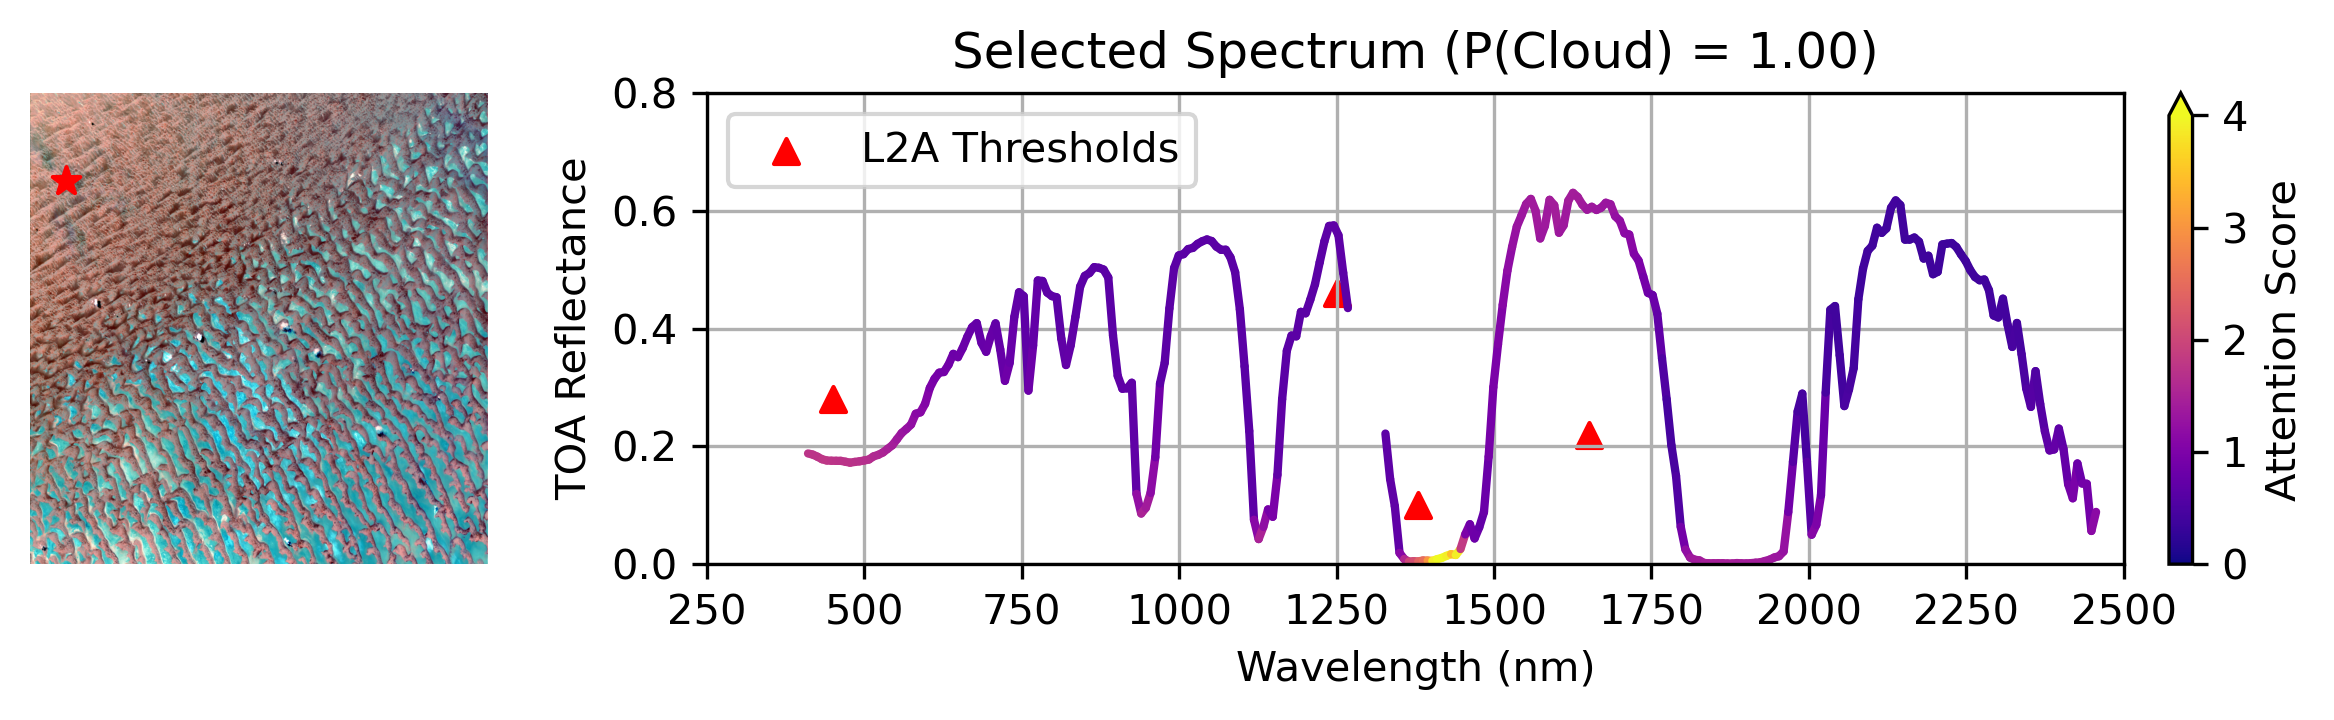

In [3]:
ACQROOT = '/store/emit/ops/data/acquisitions/'
OUTROOT = '/scratch/jakelee/emit-cloud/outputs/v6_m4/20241016/'
MODEL = '/home/jakelee/cloud/models/v6_m4.pt'
FID = "emit20230425t082443"

rgb_fp = get_rdn_png(ACQROOT, FID)
rdn_fp = get_rdn_hdr(ACQROOT, FID)
obs_fp = get_obs_hdr(ACQROOT, FID)

print('Loading TOA...')
TOA_arr, banddef, _ = l1b_to_toa_arr(rdn_fp, obs_fp, '/home/jakelee/cloud/emit-cloud-screening/jakelee/irr.npy')
print('Done.', TOA_arr.shape)

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(8,2.5), dpi=300, gridspec_kw={'width_ratios': [1, 3]})

rgb = get_raster(op.join(OUTROOT, 'rgb_png'), FID, ext='png')
plot_png(rgb, ax0, '')

tf_mask = get_raster(op.join(OUTROOT, 'tf_mask_nodata'), FID)
mask_arr = rio.open(tf_mask).read(1)

x=97
y=239
drop = [120, 121, 122, 123, 124, 125, 126]

# Get spectrum
spec = TOA_arr[y][x]

# Get probability
proba = mask_arr[y][x]
#proba = mask_arr[x][y]

# Get attention
_, attn_sum, attn_out = get_attn(banddef, spec, MODEL)
attn_dropped = np.zeros((268,))
attn_dropped = attn_sum.flatten()
#attn_dropped = np.log(attn_dropped)

# Embed into full spectrum
attn_full = np.zeros((285,))
attn_full[:] = np.nan
attn_full[4:120] = attn_dropped[:116]
attn_full[127:279] = attn_dropped[116:]
spec[drop] = np.nan

lc = LineCollection([], linewidths=2, cmap='plasma', capstyle='round')
points = np.array([banddef, spec]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc.set_segments(segments)
lc.set_array(attn_full)
lc.set_clim(0, 4)

ax1.add_collection(lc)
cbar = plt.colorbar(lc, ax=ax1, fraction=0.03, pad=0.03, extend='max')
cbar.set_label('Attention Score')

ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('TOA Reflectance')
ax1.set_xlim(250, 2500)
ax1.set_ylim(0, 0.8)
ax1.set_title(f"Selected Spectrum (P(Cloud) = {proba:.2f})")
ax1.grid(True)

ax1.scatter([450, 1250, 1650, 1380], [0.28, 0.46, 0.22, 0.1], marker='^', label="L2A Thresholds", zorder=0, c='r')
ax1.legend(loc='upper left')

ax0.scatter(x, y, marker='*', c='r', s=48)

fig.tight_layout()
fig.show()
fig.savefig('fig3b.png')